# Defining Parameter Samples in fmdtools

Parameter Samples are used to evaluate the performance of a model over a set of input parameters. It can then be used to do things like:
- define/understand the operational envelope for different system parameters (i.e., what inputs can the system safely encounter)
- quantify failure probabilities given stochastic inputs (i.e., if the statistical distribution of inputs are known, what is the resulting probability of hazards given the design)

In [1]:
import fmdtools.sim.propagate as prop
import inspect

The rover model (`rover_model.py`) from the examples module will be used to demonstrate this approach. The main task of the rover is to follow a given line from a starting location to an ending location. 

In [2]:
from examples.rover.rover_model import Rover

Additionally, this model has a corresponding `Parameter` class which generates the design parameters of the model given a reduced space of input parameters. 

In [3]:
from examples.rover.rover_model import RoverParam
print(inspect.getsource(RoverParam))

class RoverParam(Parameter):
    """Parameters for rover."""

    ground: GroundParam = GroundParam()
    correction: ResCorrection = ResCorrection()
    degradation: DegParam = DegParam()
    drive_modes: dict = {"mode_args": "set"}

    def __init__(self, *args, **kwargs):
        super().__init__(*args, strict_immutability=False, **kwargs)



This parameter is in turn made of other parameters:

In [4]:
from rover_model import GroundParam
print(inspect.getsource(GroundParam))

class GroundParam(Parameter):
    """
    Parameter defining line for rover to follow.

    Fields
    ------
    linetype: str
        line type (sine or turn)
    amp: float
        sine amplitude
    period: float
        sine period
    radius: float
        turn radius
    x_start: float
        turn starting x-value
    y_end: float
        turn y-distance (after turn/radius) before end
    x_min: float
        minimum x-value for line generation (sine or turn)
    x_max: float
        maximum x-value for line generation (sine)
    x_res: float
        resolution for line generation
    """

    linetype: str = 'sine'
    linetype_set = ("sine", "turn")
    amp: float = 1.0
    period: float = 2 * np.pi
    radius: float = 20.0
    x_start: float = 10.0
    y_end: float = 10.0
    x_min: float = 0.0
    x_max: float = 30.0
    x_res: float = 0.1
    path_buffer_on: float = 0.2
    path_buffer_poor: float = 0.3
    path_buffer_near: float = 0.4
    dest_buffer_on: float = 1.0
    

Below shows the performance of the rover during a (default) turn with a radius of 20 meters that begins at 20 meters. As shown, there is a slight drift from the centerline, but not enough for the rover to get lost (that would take 1 meter of drift).

In [5]:
p = RoverParam(ground=dict(linetype="turn"))
mdl = Rover(p=p)
results, mdlhist = prop.nominal(mdl)

(<Figure size 400x400 with 1 Axes>, <Axes: >)

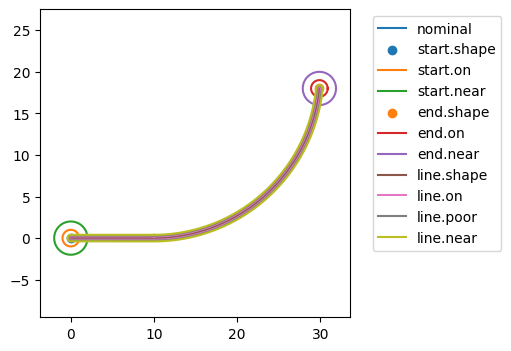

In [6]:
fig, ax = mdlhist.plot_trajectories("flows.pos.s.x", "flows.pos.s.y")
mdl.flows['ground'].ga.show(fig=fig, ax=ax)

Below shows the performance of the model over a sine wave. As shown, similar to the turn line type, the drift small enough to where the rover completes its mission within acceptable bounds.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

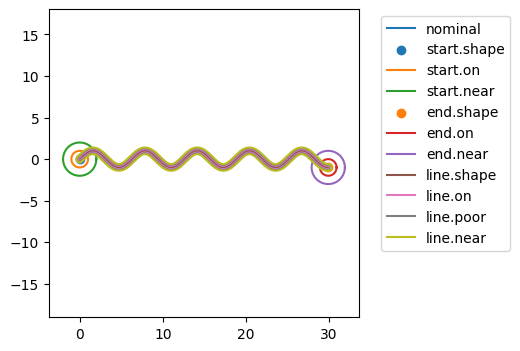

In [7]:
p = RoverParam(ground=dict(linetype="sine"))
mdl = Rover(p=p)
results, mdlhist = prop.nominal(mdl)
fig, ax = mdlhist.plot_trajectories("flows.pos.s.x", "flows.pos.s.y")
mdl.flows['ground'].ga.show(fig=fig, ax=ax)

The performance of the rover in these situations is dependent on the parameters of the situation (e.g., the radius of the curve and the amplitude of the sine wave). Thus, it is important to define the operational envelope for the system. This can be done using a `ParameterDomain`, which can be used to define ranges of variables to simulate the system under, and a `ParameterSample`, which then samples these ranges.

In [8]:
from fmdtools.sim.sample import ParameterDomain, ParameterSample

In this approach we define a parameter domain for the sine wave scenario.

Here we specify the linetype as sine (As a constant) and then add the variables "amp" and "period" which we will then sample:

In [9]:
pd_sine = ParameterDomain(RoverParam)
pd_sine.add_constant("ground.linetype", "sine")
pd_sine.add_variables("ground.amp", "ground.period", lims={"ground.amp":(0, 8), "ground.period": (10, 50)})

pd_sine

ParameterDomain with:
 - variables: {'ground.amp': (0, 8), 'ground.period': (10, 50)}
 - constants: {'ground.linetype': 'sine'}
 - parameter_initializer: RoverParam

These can then be sampled using the `ParameterSample`. 

Below we specify that we will sample the given variables in combination at certain resolutions:

In [10]:
ps_sine = ParameterSample(pd_sine)
ps_sine.add_variable_ranges(comb_kwargs={'resolutions':{'ground.amp': 0.5, "ground.period": 10}})

ps_sine

ParameterSample of scenarios:
 - rep0_range_0
 - rep0_range_1
 - rep0_range_2
 - rep0_range_3
 - rep0_range_4
 - rep0_range_5
 - rep0_range_6
 - rep0_range_7
 - rep0_range_8
 - rep0_range_9
 - ... (85 total)

Notice that the properties of the scenarios are stored in their corresponding `ParameterScenario`s.

In [11]:
ps_sine.scenarios()

[ParameterScenario(sequence={}, times=(), p={'ground': {'amp': 0.0, 'period': 10, 'linetype': 'sine'}}, r={}, sp={}, prob=0.011764705882352941, inputparams={0: 0.0, 1: 10}, rangeid='', name='rep0_range_0'),
 ParameterScenario(sequence={}, times=(), p={'ground': {'amp': 0.0, 'period': 20, 'linetype': 'sine'}}, r={}, sp={}, prob=0.011764705882352941, inputparams={0: 0.0, 1: 20}, rangeid='', name='rep0_range_1'),
 ParameterScenario(sequence={}, times=(), p={'ground': {'amp': 0.0, 'period': 30, 'linetype': 'sine'}}, r={}, sp={}, prob=0.011764705882352941, inputparams={0: 0.0, 1: 30}, rangeid='', name='rep0_range_2'),
 ParameterScenario(sequence={}, times=(), p={'ground': {'amp': 0.0, 'period': 40, 'linetype': 'sine'}}, r={}, sp={}, prob=0.011764705882352941, inputparams={0: 0.0, 1: 40}, rangeid='', name='rep0_range_3'),
 ParameterScenario(sequence={}, times=(), p={'ground': {'amp': 0.0, 'period': 50, 'linetype': 'sine'}}, r={}, sp={}, prob=0.011764705882352941, inputparams={0: 0.0, 1: 50},

ParameterSamples are sampled using `prop.parameter_sample`:

In [12]:
res, hist = prop.parameter_sample(mdl, ps_sine)
res

SCENARIOS COMPLETE:   0%|          | 0/85 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   1%|          | 1/85 [00:00<00:16,  5.00it/s]

SCENARIOS COMPLETE:   2%|▏         | 2/85 [00:00<00:16,  4.94it/s]

SCENARIOS COMPLETE:   4%|▎         | 3/85 [00:00<00:16,  4.98it/s]

SCENARIOS COMPLETE:   5%|▍         | 4/85 [00:00<00:16,  4.99it/s]

SCENARIOS COMPLETE:   6%|▌         | 5/85 [00:01<00:16,  4.96it/s]

SCENARIOS COMPLETE:   7%|▋         | 6/85 [00:01<00:16,  4.84it/s]

SCENARIOS COMPLETE:   8%|▊         | 7/85 [00:01<00:16,  4.82it/s]

SCENARIOS COMPLETE:   9%|▉         | 8/85 [00:01<00:15,  4.83it/s]

SCENARIOS COMPLETE:  11%|█         | 9/85 [00:01<00:15,  4.83it/s]

SCENARIOS COMPLETE:  12%|█▏        | 10/85 [00:02<00:15,  4.86it/s]

SCENARIOS COMPLETE:  13%|█▎        | 11/85 [00:02<00:15,  4.85it/s]

SCENARIOS COMPLETE:  14%|█▍        | 12/85 [00:02<00:15,  4.81it/s]

SCENARIOS COMPLETE:  15%|█▌        | 13/85 [00:02<00:14,  4.83it/s]

SCENARIOS COMPLETE:  16%|█▋        | 14/85 [00:02<00:14,  4.83it/s]

SCENARIOS COMPLETE:  18%|█▊        | 15/85 [00:03<00:14,  4.83it/s]

SCENARIOS COMPLETE:  19%|█▉        | 16/85 [00:03<00:14,  4.84it/s]

SCENARIOS COMPLETE:  20%|██        | 17/85 [00:03<00:14,  4.83it/s]

SCENARIOS COMPLETE:  21%|██        | 18/85 [00:03<00:13,  4.79it/s]

SCENARIOS COMPLETE:  22%|██▏       | 19/85 [00:03<00:13,  4.80it/s]

SCENARIOS COMPLETE:  24%|██▎       | 20/85 [00:04<00:13,  4.79it/s]

SCENARIOS COMPLETE:  25%|██▍       | 21/85 [00:04<00:13,  4.76it/s]

SCENARIOS COMPLETE:  26%|██▌       | 22/85 [00:04<00:13,  4.79it/s]

SCENARIOS COMPLETE:  27%|██▋       | 23/85 [00:04<00:12,  4.81it/s]

SCENARIOS COMPLETE:  28%|██▊       | 24/85 [00:04<00:12,  4.70it/s]

SCENARIOS COMPLETE:  29%|██▉       | 25/85 [00:05<00:12,  4.73it/s]

SCENARIOS COMPLETE:  31%|███       | 26/85 [00:05<00:12,  4.72it/s]

SCENARIOS COMPLETE:  32%|███▏      | 27/85 [00:05<00:12,  4.66it/s]

SCENARIOS COMPLETE:  33%|███▎      | 28/85 [00:05<00:12,  4.75it/s]

SCENARIOS COMPLETE:  34%|███▍      | 29/85 [00:06<00:11,  4.78it/s]

SCENARIOS COMPLETE:  35%|███▌      | 30/85 [00:06<00:11,  4.77it/s]

SCENARIOS COMPLETE:  36%|███▋      | 31/85 [00:06<00:11,  4.76it/s]

SCENARIOS COMPLETE:  38%|███▊      | 32/85 [00:06<00:11,  4.76it/s]

SCENARIOS COMPLETE:  39%|███▉      | 33/85 [00:06<00:10,  4.81it/s]

SCENARIOS COMPLETE:  40%|████      | 34/85 [00:07<00:10,  4.82it/s]

SCENARIOS COMPLETE:  41%|████      | 35/85 [00:07<00:10,  4.81it/s]

SCENARIOS COMPLETE:  42%|████▏     | 36/85 [00:07<00:10,  4.75it/s]

SCENARIOS COMPLETE:  44%|████▎     | 37/85 [00:07<00:10,  4.75it/s]

SCENARIOS COMPLETE:  45%|████▍     | 38/85 [00:07<00:09,  4.76it/s]

SCENARIOS COMPLETE:  46%|████▌     | 39/85 [00:08<00:09,  4.77it/s]

SCENARIOS COMPLETE:  47%|████▋     | 40/85 [00:08<00:09,  4.83it/s]

SCENARIOS COMPLETE:  48%|████▊     | 41/85 [00:08<00:09,  4.81it/s]

SCENARIOS COMPLETE:  49%|████▉     | 42/85 [00:08<00:08,  4.78it/s]

SCENARIOS COMPLETE:  51%|█████     | 43/85 [00:08<00:08,  4.76it/s]

SCENARIOS COMPLETE:  52%|█████▏    | 44/85 [00:09<00:08,  4.75it/s]

SCENARIOS COMPLETE:  53%|█████▎    | 45/85 [00:09<00:08,  4.75it/s]

SCENARIOS COMPLETE:  54%|█████▍    | 46/85 [00:09<00:08,  4.74it/s]

SCENARIOS COMPLETE:  55%|█████▌    | 47/85 [00:09<00:08,  4.72it/s]

SCENARIOS COMPLETE:  56%|█████▋    | 48/85 [00:10<00:07,  4.66it/s]

SCENARIOS COMPLETE:  58%|█████▊    | 49/85 [00:10<00:07,  4.59it/s]

SCENARIOS COMPLETE:  59%|█████▉    | 50/85 [00:10<00:07,  4.57it/s]

SCENARIOS COMPLETE:  60%|██████    | 51/85 [00:10<00:07,  4.54it/s]

SCENARIOS COMPLETE:  61%|██████    | 52/85 [00:10<00:07,  4.58it/s]

SCENARIOS COMPLETE:  62%|██████▏   | 53/85 [00:11<00:06,  4.62it/s]

SCENARIOS COMPLETE:  64%|██████▎   | 54/85 [00:11<00:06,  4.61it/s]

SCENARIOS COMPLETE:  65%|██████▍   | 55/85 [00:11<00:06,  4.63it/s]

SCENARIOS COMPLETE:  66%|██████▌   | 56/85 [00:11<00:06,  4.63it/s]

SCENARIOS COMPLETE:  67%|██████▋   | 57/85 [00:11<00:06,  4.62it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 58/85 [00:12<00:05,  4.67it/s]

SCENARIOS COMPLETE:  69%|██████▉   | 59/85 [00:12<00:05,  4.69it/s]

SCENARIOS COMPLETE:  71%|███████   | 60/85 [00:12<00:05,  4.72it/s]

SCENARIOS COMPLETE:  72%|███████▏  | 61/85 [00:12<00:04,  5.00it/s]

SCENARIOS COMPLETE:  73%|███████▎  | 62/85 [00:13<00:04,  4.90it/s]

SCENARIOS COMPLETE:  74%|███████▍  | 63/85 [00:13<00:04,  4.80it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 64/85 [00:13<00:04,  4.77it/s]

SCENARIOS COMPLETE:  76%|███████▋  | 65/85 [00:13<00:04,  4.79it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 66/85 [00:13<00:03,  5.03it/s]

SCENARIOS COMPLETE:  79%|███████▉  | 67/85 [00:14<00:03,  4.92it/s]

SCENARIOS COMPLETE:  80%|████████  | 68/85 [00:14<00:03,  4.83it/s]

SCENARIOS COMPLETE:  81%|████████  | 69/85 [00:14<00:03,  4.78it/s]

SCENARIOS COMPLETE:  82%|████████▏ | 70/85 [00:14<00:03,  4.76it/s]

SCENARIOS COMPLETE:  84%|████████▎ | 71/85 [00:14<00:02,  5.01it/s]

SCENARIOS COMPLETE:  85%|████████▍ | 72/85 [00:15<00:02,  4.90it/s]

SCENARIOS COMPLETE:  86%|████████▌ | 73/85 [00:15<00:02,  4.79it/s]

SCENARIOS COMPLETE:  87%|████████▋ | 74/85 [00:15<00:02,  4.75it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 75/85 [00:15<00:02,  4.72it/s]

SCENARIOS COMPLETE:  89%|████████▉ | 76/85 [00:15<00:01,  4.92it/s]

SCENARIOS COMPLETE:  91%|█████████ | 77/85 [00:16<00:01,  4.84it/s]

SCENARIOS COMPLETE:  92%|█████████▏| 78/85 [00:16<00:01,  4.78it/s]

SCENARIOS COMPLETE:  93%|█████████▎| 79/85 [00:16<00:01,  4.72it/s]

SCENARIOS COMPLETE:  94%|█████████▍| 80/85 [00:16<00:01,  4.74it/s]

SCENARIOS COMPLETE:  95%|█████████▌| 81/85 [00:16<00:00,  4.96it/s]

SCENARIOS COMPLETE:  96%|█████████▋| 82/85 [00:17<00:00,  4.87it/s]

SCENARIOS COMPLETE:  98%|█████████▊| 83/85 [00:17<00:00,  4.77it/s]

SCENARIOS COMPLETE:  99%|█████████▉| 84/85 [00:17<00:00,  4.76it/s]

SCENARIOS COMPLETE: 100%|██████████| 85/85 [00:17<00:00,  4.76it/s]

SCENARIOS COMPLETE: 100%|██████████| 85/85 [00:17<00:00,  4.78it/s]

rep0_range_0.endclass.rate:          1.0
rep0_range_0.endclass.cost:            0
rep0_range_0.endclass.prob: 0.011764705882352941
rep0_range_0.endclass.expected_cost:   0
rep0_range_0.endclass.in_bound:     True
rep0_range_0.endclass.at_finish:    True
rep0_range_0.endclass.line_dist:       1
rep0_range_0.endclass.num_modes:       0
rep0_range_0.endclass.end_dist:      0.0
rep0_range_0.endclass.tot_deviation: 0.0
rep0_range_0.endclass.faults:         {}
rep0_range_0.endclass.classification: nominal mission
rep0_range_0.endclass.end_x: 28.999999999999964
rep0_range_0.endclass.end_y:         0.0
rep0_range_0.endclass.endpt:    array(2)
rep0_range_1.endclass.rate:          1.0
rep0_range_1.endclass.cost:            0
rep0_range_1.endclass.prob: 0.011764705882352941
rep0_range_1.endclass.expected_cost:   0
rep0_range_1.endclass.in_bound:     True
rep0_range_1.endclass.at_finish:    True
rep0_range_1.endclass.line_dist:       1
rep0_range_1.endclass.num_modes:       0
rep0_range_1.endclass

To speed up execution over large numbers of scenarios, multiprocessing can also be used to run the scenarios in parallel by passing an execution pool. This is not done here because it would require the model to be in a different file, and because the gains on a light-weight model like this are not significant.

Now that the approach has been simulated, the operational envelope can be visualized using the `fmdtools.analyze.tabulate.NominalEnvelope` class, which can be used to plot the *classification* of the model in the 1/2/3 dimensions over the set of given parameters as nominal or incomplete. 

Note that this classification must be in the dictionary returned from the Model's `find_classification` function at the end of the model run under the key `classification` as is done in the rover model. This classification must also be encoded as a string.

In [13]:
from fmdtools.analyze.tabulate import NominalEnvelope

We can then use these results to visualize the operational envelope for the system over each case. In this case, the parameter ranges of the sine wave are plotted, showing that the rover can only a low ration of amplitude to wavelenght.

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='p.ground.amp', ylabel='p.ground.period'>)

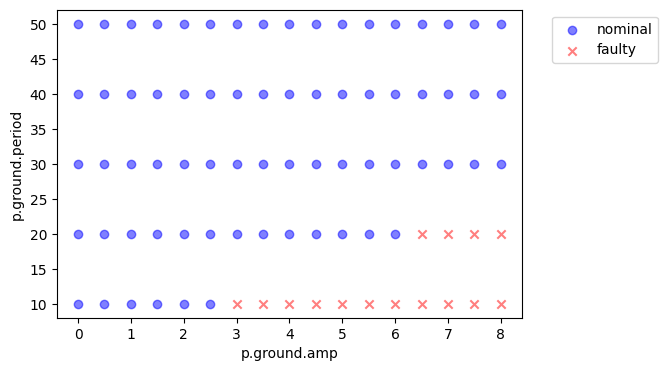

In [14]:
ne = NominalEnvelope(ps_sine, res, 'at_finish', 'p.ground.amp', 'p.ground.period', func=lambda x: x == True)
ne.as_plot()

While this is helpful for plotting string classifications, we also might want to compare numeric quantities (e.g., costs, hazard probabilities, etc) over the set of factors. For this, `fmdtools.analyze.tabulate.Comparison` is used, which creates a comparison which can be visualized as a table or plot.

In [15]:
from fmdtools.analyze.tabulate import Comparison

comp = Comparison(res, ps_sine, metrics=['end_dist', 'tot_deviation'], factors=['p.ground.amp', 'p.ground.period'])
comp.sort_by_metric("end_dist")
comp.as_table()

end_dist  tot_deviation
8.0 10  27.106630       0.229147
7.0 10  26.823138       0.206451
7.5 10  27.100934       0.206165
6.0 10  26.345580       0.203384
6.5 10  26.579662       0.202847
...           ...            ...
0.0 30   0.000000       0.000000
    20   0.000000       0.000000
    40   0.000000       0.000000
    10   0.000000       0.000000
    50   0.000000       0.000000

[85 rows x 2 columns]

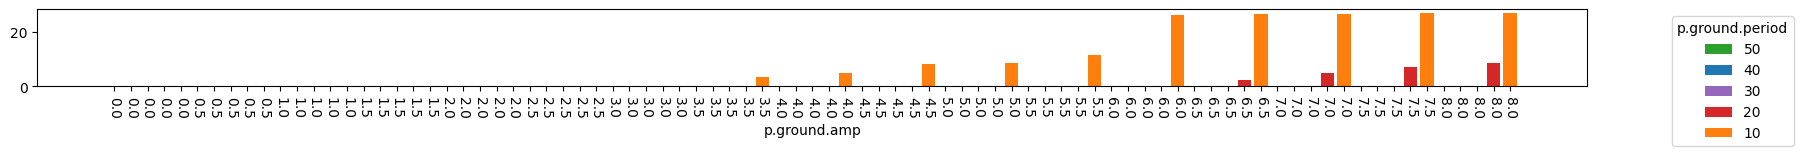

In [16]:
comp.sort_by_factor("p.ground.period", reverse=True)
comp.sort_by_factor("p.ground.amp")
fig, ax = comp.as_plot("end_dist", color_factor = "p.ground.period", figsize=(20, 1))

This table can also be summarized on individual factors:

In [17]:
scomp = Comparison(res, ps_sine, metrics=['end_dist'], factors=['p.ground.amp'])
scomp.sort_by_factor('p.ground.amp')
scomp.as_table()

,end_dist
8.0,35.558231
7.5,34.273011
7.0,31.529777
6.5,28.778543
6.0,26.345580
5.5,11.544091
5.0,8.621391
4.5,8.159540
4.0,4.796435
3.5,3.249137


(<Figure size 600x400 with 1 Axes>, <Axes: xlabel='p.ground.amp'>)

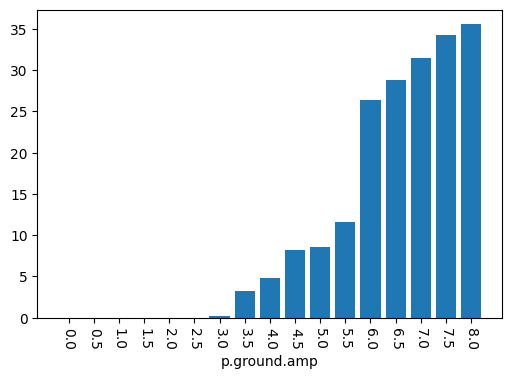

In [18]:
scomp.as_plot("end_dist")

## Quantifying probabilities

Given the ability to simulate over ranges, it can additionally be used to quantify probabilities of the different end-state classifications. `Result.state_probabilities()` can be used to quantify the probability these classifications.

In [19]:
res.state_probabilities()

{'nominal mission': 0.8235294117647052,
 'incomplete mission': 0.17647058823529416}

## Nested Scenario Sampling

Thus far, we have introduced two types of samples 
- `FaultSample`, which is used to evaluate the system resilience to a set of faults
- `ParameterSample`, which is used to evaluate system performance over a set of parameters

These both have their limitations when used alone. Simulating a `FaultSample` using `propagate.fault_sample` solely evaluates evaluates fault-driven hazards in a single nominal set of parameters (which may not generalize) while simulating a `ParameterSample` using `propagate.parameter_sample` evaluates the systerm performance/resilience to external parameters (But not faults).

To resolve these limitations, one can use a *nested* scenario sampling approach where a `SampleApproach` is simulated at each parameter level of a `ParameterSample`, giving the resilience of the system to faults over a set of operational parameters. This is called using the `propagate.nested_sample` method.

Here we use the nominal approach generated earlier with a default sampling approach to quantify resilience.

In [20]:
from fmdtools.sim.sample import SampleApproach
sa = SampleApproach(mdl)
# adding fault domains
sa.add_faultdomain("power", "all_fxn_modes", "power")
sa.add_faultsample("power", "fault_times", "power", [1,2])
sa

SampleApproach for rover with: 
 faultdomains: power
 faultsamples: power

In [21]:

nest_res, nest_hist, apps = prop.nested_sample(mdl, ps_sine,
                                               faultdomains = {"power": (('all_fxn_modes', 'power'), {})},
                                               faultsamples = {"power": (("fault_times", "power", [1,2]), {})})

NESTED SCENARIOS COMPLETE:   0%|          | 0/85 [00:00<?, ?it/s]

NESTED SCENARIOS COMPLETE:   1%|          | 1/85 [00:00<00:54,  1.55it/s]

NESTED SCENARIOS COMPLETE:   2%|▏         | 2/85 [00:01<00:53,  1.54it/s]

NESTED SCENARIOS COMPLETE:   4%|▎         | 3/85 [00:01<00:53,  1.55it/s]

NESTED SCENARIOS COMPLETE:   5%|▍         | 4/85 [00:02<00:52,  1.55it/s]

NESTED SCENARIOS COMPLETE:   6%|▌         | 5/85 [00:03<00:52,  1.54it/s]

NESTED SCENARIOS COMPLETE:   7%|▋         | 6/85 [00:03<00:52,  1.52it/s]

NESTED SCENARIOS COMPLETE:   8%|▊         | 7/85 [00:04<00:51,  1.50it/s]

NESTED SCENARIOS COMPLETE:   9%|▉         | 8/85 [00:05<00:51,  1.50it/s]

NESTED SCENARIOS COMPLETE:  11%|█         | 9/85 [00:05<00:51,  1.49it/s]

NESTED SCENARIOS COMPLETE:  12%|█▏        | 10/85 [00:06<00:49,  1.50it/s]

NESTED SCENARIOS COMPLETE:  13%|█▎        | 11/85 [00:07<00:50,  1.46it/s]

NESTED SCENARIOS COMPLETE:  14%|█▍        | 12/85 [00:08<00:49,  1.47it/s]

NESTED SCENARIOS COMPLETE:  15%|█▌        | 13/85 [00:08<00:49,  1.47it/s]

NESTED SCENARIOS COMPLETE:  16%|█▋        | 14/85 [00:09<00:48,  1.47it/s]

NESTED SCENARIOS COMPLETE:  18%|█▊        | 15/85 [00:10<00:47,  1.47it/s]

NESTED SCENARIOS COMPLETE:  19%|█▉        | 16/85 [00:10<00:48,  1.43it/s]

NESTED SCENARIOS COMPLETE:  20%|██        | 17/85 [00:11<00:47,  1.43it/s]

NESTED SCENARIOS COMPLETE:  21%|██        | 18/85 [00:12<00:46,  1.45it/s]

NESTED SCENARIOS COMPLETE:  22%|██▏       | 19/85 [00:12<00:45,  1.46it/s]

NESTED SCENARIOS COMPLETE:  24%|██▎       | 20/85 [00:13<00:44,  1.46it/s]

NESTED SCENARIOS COMPLETE:  25%|██▍       | 21/85 [00:14<00:46,  1.38it/s]

NESTED SCENARIOS COMPLETE:  26%|██▌       | 22/85 [00:15<00:45,  1.39it/s]

NESTED SCENARIOS COMPLETE:  27%|██▋       | 23/85 [00:15<00:44,  1.41it/s]

NESTED SCENARIOS COMPLETE:  28%|██▊       | 24/85 [00:16<00:43,  1.39it/s]

NESTED SCENARIOS COMPLETE:  29%|██▉       | 25/85 [00:17<00:42,  1.41it/s]

NESTED SCENARIOS COMPLETE:  31%|███       | 26/85 [00:17<00:44,  1.33it/s]

NESTED SCENARIOS COMPLETE:  32%|███▏      | 27/85 [00:18<00:43,  1.34it/s]

NESTED SCENARIOS COMPLETE:  33%|███▎      | 28/85 [00:19<00:41,  1.37it/s]

NESTED SCENARIOS COMPLETE:  34%|███▍      | 29/85 [00:20<00:40,  1.40it/s]

NESTED SCENARIOS COMPLETE:  35%|███▌      | 30/85 [00:20<00:38,  1.42it/s]

NESTED SCENARIOS COMPLETE:  36%|███▋      | 31/85 [00:21<00:41,  1.30it/s]

NESTED SCENARIOS COMPLETE:  38%|███▊      | 32/85 [00:22<00:40,  1.31it/s]

NESTED SCENARIOS COMPLETE:  39%|███▉      | 33/85 [00:23<00:38,  1.34it/s]

NESTED SCENARIOS COMPLETE:  40%|████      | 34/85 [00:23<00:37,  1.37it/s]

NESTED SCENARIOS COMPLETE:  41%|████      | 35/85 [00:24<00:35,  1.39it/s]

NESTED SCENARIOS COMPLETE:  42%|████▏     | 36/85 [00:25<00:38,  1.29it/s]

NESTED SCENARIOS COMPLETE:  44%|████▎     | 37/85 [00:26<00:37,  1.29it/s]

NESTED SCENARIOS COMPLETE:  45%|████▍     | 38/85 [00:26<00:35,  1.32it/s]

NESTED SCENARIOS COMPLETE:  46%|████▌     | 39/85 [00:27<00:34,  1.35it/s]

NESTED SCENARIOS COMPLETE:  47%|████▋     | 40/85 [00:28<00:32,  1.38it/s]

NESTED SCENARIOS COMPLETE:  48%|████▊     | 41/85 [00:29<00:34,  1.28it/s]

NESTED SCENARIOS COMPLETE:  49%|████▉     | 42/85 [00:30<00:33,  1.27it/s]

NESTED SCENARIOS COMPLETE:  51%|█████     | 43/85 [00:30<00:32,  1.30it/s]

NESTED SCENARIOS COMPLETE:  52%|█████▏    | 44/85 [00:31<00:30,  1.33it/s]

NESTED SCENARIOS COMPLETE:  53%|█████▎    | 45/85 [00:32<00:29,  1.37it/s]

NESTED SCENARIOS COMPLETE:  54%|█████▍    | 46/85 [00:33<00:30,  1.27it/s]

NESTED SCENARIOS COMPLETE:  55%|█████▌    | 47/85 [00:33<00:30,  1.26it/s]

NESTED SCENARIOS COMPLETE:  56%|█████▋    | 48/85 [00:34<00:28,  1.28it/s]

NESTED SCENARIOS COMPLETE:  58%|█████▊    | 49/85 [00:35<00:27,  1.32it/s]

NESTED SCENARIOS COMPLETE:  59%|█████▉    | 50/85 [00:36<00:25,  1.35it/s]

NESTED SCENARIOS COMPLETE:  60%|██████    | 51/85 [00:36<00:26,  1.26it/s]

NESTED SCENARIOS COMPLETE:  61%|██████    | 52/85 [00:37<00:26,  1.23it/s]

NESTED SCENARIOS COMPLETE:  62%|██████▏   | 53/85 [00:38<00:25,  1.26it/s]

NESTED SCENARIOS COMPLETE:  64%|██████▎   | 54/85 [00:39<00:24,  1.29it/s]

NESTED SCENARIOS COMPLETE:  65%|██████▍   | 55/85 [00:40<00:22,  1.32it/s]

NESTED SCENARIOS COMPLETE:  66%|██████▌   | 56/85 [00:40<00:22,  1.26it/s]

NESTED SCENARIOS COMPLETE:  67%|██████▋   | 57/85 [00:41<00:23,  1.19it/s]

NESTED SCENARIOS COMPLETE:  68%|██████▊   | 58/85 [00:42<00:22,  1.22it/s]

NESTED SCENARIOS COMPLETE:  69%|██████▉   | 59/85 [00:43<00:20,  1.26it/s]

NESTED SCENARIOS COMPLETE:  71%|███████   | 60/85 [00:44<00:19,  1.30it/s]

NESTED SCENARIOS COMPLETE:  72%|███████▏  | 61/85 [00:44<00:15,  1.53it/s]

NESTED SCENARIOS COMPLETE:  73%|███████▎  | 62/85 [00:45<00:16,  1.37it/s]

NESTED SCENARIOS COMPLETE:  74%|███████▍  | 63/85 [00:46<00:16,  1.34it/s]

NESTED SCENARIOS COMPLETE:  75%|███████▌  | 64/85 [00:46<00:15,  1.34it/s]

NESTED SCENARIOS COMPLETE:  76%|███████▋  | 65/85 [00:47<00:14,  1.36it/s]

NESTED SCENARIOS COMPLETE:  78%|███████▊  | 66/85 [00:47<00:12,  1.58it/s]

NESTED SCENARIOS COMPLETE:  79%|███████▉  | 67/85 [00:48<00:12,  1.39it/s]

NESTED SCENARIOS COMPLETE:  80%|████████  | 68/85 [00:49<00:12,  1.34it/s]

NESTED SCENARIOS COMPLETE:  81%|████████  | 69/85 [00:50<00:11,  1.34it/s]

NESTED SCENARIOS COMPLETE:  82%|████████▏ | 70/85 [00:51<00:11,  1.36it/s]

NESTED SCENARIOS COMPLETE:  84%|████████▎ | 71/85 [00:51<00:08,  1.59it/s]

NESTED SCENARIOS COMPLETE:  85%|████████▍ | 72/85 [00:52<00:09,  1.41it/s]

NESTED SCENARIOS COMPLETE:  86%|████████▌ | 73/85 [00:53<00:08,  1.34it/s]

NESTED SCENARIOS COMPLETE:  87%|████████▋ | 74/85 [00:54<00:08,  1.33it/s]

NESTED SCENARIOS COMPLETE:  88%|████████▊ | 75/85 [00:54<00:07,  1.34it/s]

NESTED SCENARIOS COMPLETE:  89%|████████▉ | 76/85 [00:55<00:05,  1.56it/s]

NESTED SCENARIOS COMPLETE:  91%|█████████ | 77/85 [00:56<00:05,  1.37it/s]

NESTED SCENARIOS COMPLETE:  92%|█████████▏| 78/85 [00:56<00:05,  1.30it/s]

NESTED SCENARIOS COMPLETE:  93%|█████████▎| 79/85 [00:57<00:04,  1.29it/s]

NESTED SCENARIOS COMPLETE:  94%|█████████▍| 80/85 [00:58<00:03,  1.30it/s]

NESTED SCENARIOS COMPLETE:  95%|█████████▌| 81/85 [00:58<00:02,  1.53it/s]

NESTED SCENARIOS COMPLETE:  96%|█████████▋| 82/85 [00:59<00:02,  1.36it/s]

NESTED SCENARIOS COMPLETE:  98%|█████████▊| 83/85 [01:00<00:01,  1.29it/s]

NESTED SCENARIOS COMPLETE:  99%|█████████▉| 84/85 [01:01<00:00,  1.29it/s]

NESTED SCENARIOS COMPLETE: 100%|██████████| 85/85 [01:02<00:00,  1.30it/s]

NESTED SCENARIOS COMPLETE: 100%|██████████| 85/85 [01:02<00:00,  1.37it/s]

 The resulting endclass/mdlhist dictionary is in turn nested within operational scenarios.

In [22]:
nest_res.keys()

dict_keys(['rep0_range_0.power_no_charge_t1.endclass.rate', 'rep0_range_0.power_no_charge_t1.endclass.cost', 'rep0_range_0.power_no_charge_t1.endclass.prob', 'rep0_range_0.power_no_charge_t1.endclass.expected_cost', 'rep0_range_0.power_no_charge_t1.endclass.in_bound', 'rep0_range_0.power_no_charge_t1.endclass.at_finish', 'rep0_range_0.power_no_charge_t1.endclass.line_dist', 'rep0_range_0.power_no_charge_t1.endclass.num_modes', 'rep0_range_0.power_no_charge_t1.endclass.end_dist', 'rep0_range_0.power_no_charge_t1.endclass.tot_deviation', 'rep0_range_0.power_no_charge_t1.endclass.faults', 'rep0_range_0.power_no_charge_t1.endclass.classification', 'rep0_range_0.power_no_charge_t1.endclass.end_x', 'rep0_range_0.power_no_charge_t1.endclass.end_y', 'rep0_range_0.power_no_charge_t1.endclass.endpt', 'rep0_range_0.power_no_charge_t2.endclass.rate', 'rep0_range_0.power_no_charge_t2.endclass.cost', 'rep0_range_0.power_no_charge_t2.endclass.prob', 'rep0_range_0.power_no_charge_t2.endclass.expected_

In [23]:
apps

{'rep0_range_0': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_1': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_2': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_3': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_4': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_5': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_6': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_7': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_8': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_9': SampleApproach for rover with: 
  faultdomains: power
  faultsamples: power,
 'rep0_range_10': SampleApproach for rover with: 
  faultdom

We can now compare the performance of the system over faults using a `NestedComparison`:

In [24]:
import numpy as np
from fmdtools.analyze.tabulate import NestedComparison

n_comp = NestedComparison(nest_res, ps_sine, ['p.ground.amp', 'p.ground.period'], apps, [], #['fault'],
                          metrics=['end_dist'], default_stat=np.mean, ci_metrics=['end_dist'])

n_comp.as_table()

end_dist  end_dist_lb  end_dist_ub
8.0 40  14.976024     0.000000    29.952048
7.5 40  14.913633     0.000000    29.827266
7.0 40  14.854427     0.000000    29.708854
6.5 40  14.799179     0.000000    29.598357
6.0 40  14.747961     0.000000    29.495921
...           ...          ...          ...
0.0 10  14.450000     0.000000    28.900000
    30  14.450000     0.000000    28.900000
    50  14.450000     0.000000    28.900000
7.5 10  28.002385    27.100934    28.453111
7.0 10  27.863240    26.823138    28.383291

[85 rows x 3 columns]

(<Figure size 2000x300 with 1 Axes>, <Axes: xlabel='p.ground.amp'>)

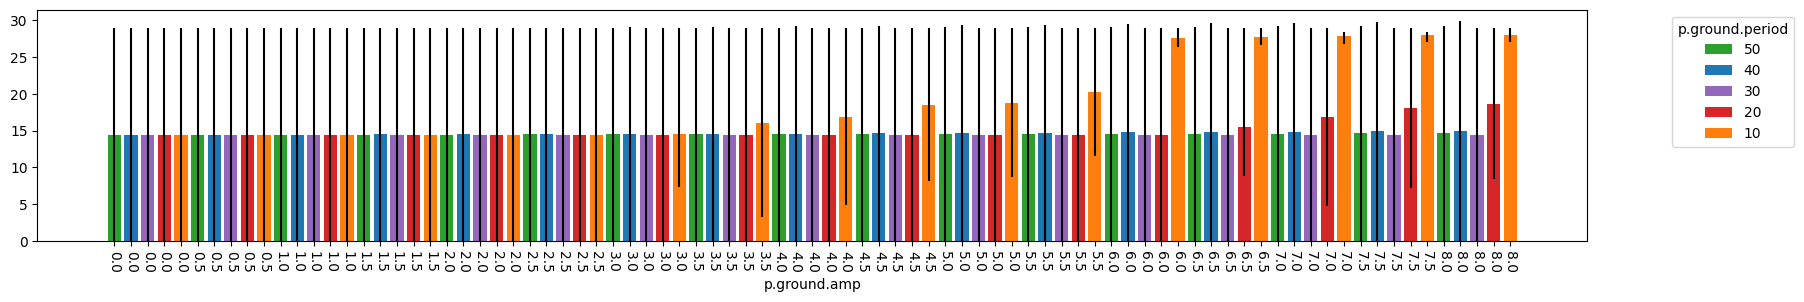

In [25]:
n_comp.sort_by_factor("p.ground.period", reverse=True)
n_comp.sort_by_factor("p.ground.amp")
n_comp.as_plot("end_dist", color_factor="p.ground.period", figsize=(20,3))

This is of course consistent with the nominal case, with a higher average in all cases, since fault modes inherently deviate the trajectory.

Also note the wide error bars on the fault plot--this is again because individual fault modes have a substantial impact on the trajectory (and we are only sampling a few scenarios for the bootstrap)

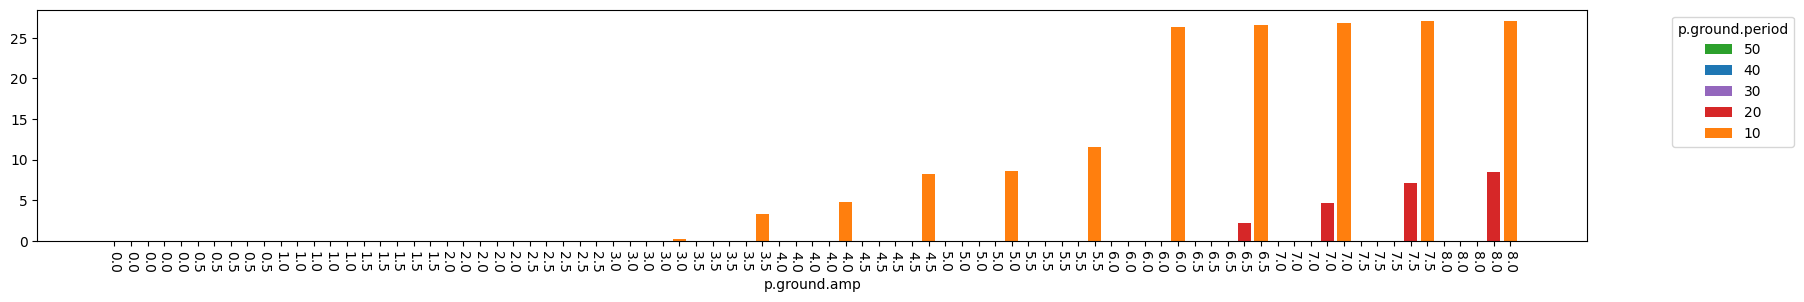

In [26]:
fig, ax = comp.as_plot("end_dist", color_factor = "p.ground.period", figsize=(20, 3))